# I. Install and import packages

In [410]:
## Install packages in the first time
# ! pip install seaborn
# ! pip install xgboost

In [411]:
#import libraries
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
from pandas.io.json import json_normalize
from itertools import chain
from sklearn.cluster import KMeans

#Using the warnings to hide the warnings
import warnings
warnings.filterwarnings("ignore")

#import plotly for visualization
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

#For model and related
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# II. Load data and first transform

In [2]:
df = pd.read_csv("Challenge_MLTrack_DataSet.csv")

In [3]:
df.head()

,csn,date,transaction_info
0,Y2NgaWJoYw==,2018-03-02,"[{'article': '10020163', 'salesquantity': 2.0,..."
1,Y2NgaWJoYw==,2018-03-04,"[{'article': '10026562', 'salesquantity': 3.0,..."
2,Y2NgaWlpYA==,2018-02-27,"[{'article': '10013531', 'salesquantity': 1.0,..."
3,Y2NgaWlpYA==,2018-03-16,"[{'article': '10008991', 'salesquantity': 1.0,..."
4,Y2NgaWlpYA==,2018-05-24,"[{'article': '10009698', 'salesquantity': 1.0,..."


In [4]:
df['transaction_info'] = df['transaction_info'].map(lambda x: x.lstrip('[').rstrip(']'))

In [5]:
# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split('}, {')))

In [6]:
# calculate lengths of splits
lens = df['transaction_info'].str.split('}, {').map(len)

In [7]:
# create new dataframe, repeating or chaining as appropriate
Newdf = pd.DataFrame({'csn': np.repeat(df['csn'], lens),
                    'date': np.repeat(df['date'], lens),
                    'transaction_info': chainer(df['transaction_info'])})

In [8]:
#Remove "{,}" in all row
Newdf['transaction_info'] = Newdf['transaction_info'].map(lambda x: x.lstrip('{').rstrip('}'))

In [9]:
Newdf['transaction_info']= Newdf['transaction_info'].apply(lambda x: "{}{}".format('{',x))
Newdf['transaction_info']= Newdf['transaction_info'].apply(lambda x: "{}{}".format(x,'}'))
Newdf['transaction_info']= Newdf['transaction_info'].str.replace('\'','\"')

In [11]:
Newdf['transaction_info'] = Newdf['transaction_info'].apply(lambda x : dict(eval(x)))
df2 = Newdf['transaction_info'].apply(pd.Series)
data = pd.concat([Newdf, df2], axis=1).drop('transaction_info', axis=1)

In [418]:
#data=pd.read_csv("Cleaned_data.csv")

In [419]:
data.head()

,Unnamed: 0,csn,date,article,salesquantity,price
0,0,Y2NgaWJoYw==,2018-03-02,10020163,2.0,18250.0
1,1,Y2NgaWJoYw==,2018-03-04,10026562,3.0,13000.0
2,1,Y2NgaWJoYw==,2018-03-04,10320883,2.0,43000.0
3,2,Y2NgaWlpYA==,2018-02-27,10013531,1.0,17800.0
4,2,Y2NgaWlpYA==,2018-02-27,10015613,1.0,5600.0


In [420]:
data['date'] = pd.to_datetime(data['date'])

In [421]:
#data.to_csv("Cleaned_data.csv")

# III. Data processing.

## 3.1 Split data

In [422]:
data_2m = data[(data.date < date(2018,6,1)) & (data.date >= date(2018,4,1))].reset_index(drop=True)
data_next = data[(data.date >= date(2018,6,1)) & (data.date < date(2018,7,1))].reset_index(drop=True)

In [423]:
data_next['date'].describe()

count                  194955
unique                     30
top       2018-06-17 00:00:00
freq                    10144
first     2018-06-01 00:00:00
last      2018-06-30 00:00:00
Name: date, dtype: object

In [424]:
data_user = pd.DataFrame(data_2m['csn'].unique())
data_user.columns = ['csn']

## 3.2 User data

In [425]:
data_user.head()

,csn
0,Y2NgaWlpYA==
1,Y2NgamRpZA==
2,Y2NgbWFn
3,Y2NgbWRn
4,Y2NgbWVlYA==


## 3.3 Adding label

We figure out the last-purchased-time, the first-purchase after 20180601 and time range between them.

In [426]:
data_next_first_purchase = data_next.groupby('csn').date.min().reset_index()

In [427]:
data_next_first_purchase.columns = ['csn','MinPurchaseDate']

In [428]:
data_next_first_purchase.head()

,csn,MinPurchaseDate
0,Y2NgamRpZA==,2018-06-08
1,Y2Ngb2FpYg==,2018-06-10
2,Y2Ngb2Ns,2018-06-25
3,Y2Ngb2RpaA==,2018-06-22
4,Y2NgbWFn,2018-06-17


In [429]:
data_last_purchase = data_2m.groupby('csn').date.max().reset_index()

In [430]:
data_last_purchase.columns = ['csn','MaxPurchaseDate']

In [431]:
data_purchase_dates = pd.merge(data_last_purchase,data_next_first_purchase,on='csn',how='left')

In [432]:
data_purchase_dates['NextPurchaseDay'] = (data_purchase_dates['MinPurchaseDate'] - data_purchase_dates['MaxPurchaseDate']).dt.days

In [433]:
data_purchase_dates.head()

,csn,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,Y2NgaWlpYA==,2018-05-24,NaT,NaN
1,Y2NgamRpZA==,2018-05-22,2018-06-08,17.0
2,Y2NgbWFn,2018-05-26,2018-06-17,22.0
3,Y2NgbWRn,2018-05-29,NaT,NaN
4,Y2NgbWVlYA==,2018-05-22,2018-06-03,12.0


In [434]:
#Add to data_user
data_user = pd.merge(data_user, data_purchase_dates[['csn','NextPurchaseDay']],on='csn',how='left')

In [435]:
print(data_user.shape)
data_user.head()

(12713, 2)


,csn,NextPurchaseDay
0,Y2NgaWlpYA==,NaN
1,Y2NgamRpZA==,17.0
2,Y2NgbWFn,22.0
3,Y2NgbWRn,NaN
4,Y2NgbWVlYA==,12.0


In [436]:
data_user = data_user.fillna(999)

## Recently purchased range

In [440]:
data_max_purchase = data_2m.groupby('csn').date.max().reset_index()

In [441]:
data_max_purchase.columns = ['csn','MaxPurchaseDate']

In [442]:
data_max_purchase['Recency'] = (data_max_purchase['MaxPurchaseDate'].max() - data_max_purchase['MaxPurchaseDate']).dt.days

In [443]:
data_user = pd.merge(data_user, data_max_purchase[['csn','Recency']], on='csn')

In [444]:
data_user.head()

,csn,NextPurchaseDay,Recency
0,Y2NgaWlpYA==,999.0,7
1,Y2NgamRpZA==,17.0,9
2,Y2NgbWFn,22.0,5
3,Y2NgbWRn,999.0,2
4,Y2NgbWVlYA==,12.0,9


In [445]:
data_user.Recency.describe()

count    12713.000000
mean        19.591914
std         17.080799
min          0.000000
25%          4.000000
50%         15.000000
75%         32.000000
max         60.000000
Name: Recency, dtype: float64

In [447]:
plot_data = [
    go.Histogram(
        x=data_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recently purchased range'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

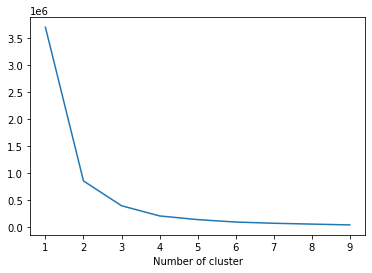

In [460]:
#Find the number of clusters
sse={}
data_recency = data_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_recency)
    data_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [449]:
#Using kmeans to cluster this feature
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_user[['Recency']])
data_user['RecencyCluster'] = kmeans.predict(data_user[['Recency']])

In [450]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [451]:
data_user = order_cluster('RecencyCluster', 'Recency',data_user,False)

In [452]:
data_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1761.0,50.772288,5.405578,42.0,46.0,50.0,55.0,60.0
1,2936.0,32.189714,4.956070,24.0,28.0,32.0,36.0,41.0
2,3104.0,15.438144,3.931090,10.0,12.0,15.0,19.0,23.0
3,4912.0,3.508347,2.672501,0.0,1.0,3.0,5.0,9.0


## Frequency of transactions

In [453]:
data_frequency = data_2m.groupby('csn').date.count().reset_index()

In [454]:
data_frequency.columns = ['csn','Frequency']

In [456]:
data_user = pd.merge(data_user, data_frequency, on='csn')

In [457]:
data_user.head()

,csn,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,Y2NgaWlpYA==,999.0,7,3,4
1,Y2NgamRpZA==,17.0,9,3,15
2,Y2NgbWFn,22.0,5,3,62
3,Y2NgbWRn,999.0,2,3,2
4,Y2NgbWVlYA==,12.0,9,3,5


In [458]:
plot_data = [
    go.Histogram(
        x=data_user.query('Frequency < 100000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency of transaction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

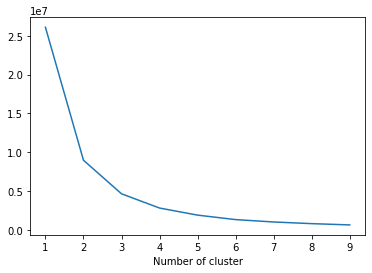

In [461]:
#Find the number of clusters
sse={}
data_frequency = data_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_frequency)
    data_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [462]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_user[['Frequency']])
data_user['FrequencyCluster'] = kmeans.predict(data_user[['Frequency']])

In [463]:
data_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2286.0,55.875328,16.514478,34.0,42.0,52.0,67.75,94.0
1,9464.0,11.267646,8.563672,1.0,4.0,9.0,16.00,33.0
2,780.0,132.607692,28.063470,95.0,109.0,126.0,153.00,198.0
3,183.0,266.672131,68.787311,200.0,216.0,243.0,293.00,511.0


In [464]:
data_user = order_cluster('FrequencyCluster', 'Frequency',data_user,True)

In [465]:
data_2m.head()

,Unnamed: 0,csn,date,article,salesquantity,price
0,4,Y2NgaWlpYA==,2018-05-24,10009698,1.00,48900.0
1,4,Y2NgaWlpYA==,2018-05-24,10009701,1.00,48900.0
2,4,Y2NgaWlpYA==,2018-05-24,10319093,5.00,56000.0
3,4,Y2NgaWlpYA==,2018-05-24,10319096,2.00,54000.0
4,11,Y2NgamRpZA==,2018-05-16,10060637,2.29,199900.0


## Total Value

In [473]:
data_2m['Revenue'] = data_2m['price'] * data_2m['salesquantity']

In [474]:
data_revenue = data_2m.groupby('csn').Revenue.sum().reset_index()

In [475]:
data_user = pd.merge(data_user, data_revenue, on='csn')

In [476]:
data_user.Revenue.describe()

count    1.271300e+04
mean     1.633129e+06
std      1.865979e+07
min      3.300000e+03
25%      2.290000e+05
50%      6.127110e+05
75%      1.654657e+06
max      2.059355e+09
Name: Revenue, dtype: float64

In [477]:
plot_data = [
    go.Histogram(
        x=data_user.query('Revenue < 1600000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Total Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

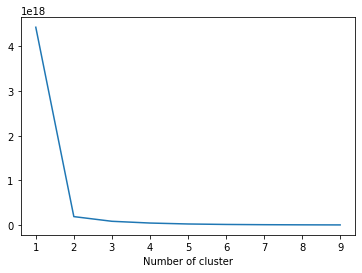

In [478]:
#Using Kmeans to cluster
sse={}
data_revenue = data_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=10000).fit(data_revenue)
    data_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [485]:
#4
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_user[['Revenue']])
data_user['RevenueCluster'] = kmeans.predict(data_user[['Revenue']])

In [486]:
data_user = order_cluster('RevenueCluster', 'Revenue',data_user,True)

In [487]:
data_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,11460.0,8.413740e+05,8.623410e+05,3.300000e+03,2.010447e+05,5.101000e+05,1.207939e+06,3.715298e+06
1,1248.0,6.736832e+06,3.650980e+06,3.716298e+06,4.521057e+06,5.749995e+06,7.535418e+06,4.848180e+07
2,4.0,1.632258e+08,8.691040e+07,9.032243e+07,1.188974e+08,1.368104e+08,1.811388e+08,2.889600e+08
3,1.0,2.059355e+09,NaN,2.059355e+09,2.059355e+09,2.059355e+09,2.059355e+09,2.059355e+09


## Combine to find the Overall Segmentation

In [489]:
data_user.head()

,csn,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue_x,Revenue_y,Revenue,RevenueCluster
0,Y2NgaWlpYA==,999.0,7,3,4,0,4.858000e+05,4.858000e+05,4.858000e+05,0
1,Y2NgamRpZA==,17.0,9,3,15,0,1.479360e+06,1.479360e+06,1.479360e+06,0
2,Y2NgbWRn,999.0,2,3,2,0,1.035000e+05,1.035000e+05,1.035000e+05,0
3,Y2NgbWVlYA==,12.0,9,3,5,0,6.586100e+04,6.586100e+04,6.586100e+04,0
4,Y2NgcGlqZQ==,1.0,0,3,33,0,6.090070e+05,6.090070e+05,6.090070e+05,0


In [490]:
data_user['OverallScore'] = data_user['RecencyCluster'] + data_user['FrequencyCluster'] + data_user['RevenueCluster']

In [491]:
data_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,50.799074,8.063694,4.058479e+05
1,32.506297,10.317021,5.185793e+05
2,16.642747,14.042824,7.076582e+05
3,6.021263,20.426889,9.497672e+05
4,4.237175,56.350186,2.409965e+06
5,4.425968,89.225513,5.945803e+06
6,2.595960,138.607744,6.439117e+06
7,1.553073,264.564246,2.299152e+07
8,0.000000,511.000000,9.032243e+07


In [492]:
data_user.groupby('OverallScore')['Recency'].count()

OverallScore
0    1727
1    2779
2    2592
3    3057
4    1345
5     439
6     594
7     179
8       1
Name: Recency, dtype: int64

In [493]:
data_user['Segment'] = 'Low-Value'
data_user.loc[data_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
data_user.loc[data_user['OverallScore']>4,'Segment'] = 'High-Value'

In [494]:
data_user.head()

,csn,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue_x,Revenue_y,Revenue,RevenueCluster,OverallScore,Segment
0,Y2NgaWlpYA==,999.0,7,3,4,0,4.858000e+05,4.858000e+05,4.858000e+05,0,3,Mid-Value
1,Y2NgamRpZA==,17.0,9,3,15,0,1.479360e+06,1.479360e+06,1.479360e+06,0,3,Mid-Value
2,Y2NgbWRn,999.0,2,3,2,0,1.035000e+05,1.035000e+05,1.035000e+05,0,3,Mid-Value
3,Y2NgbWVlYA==,12.0,9,3,5,0,6.586100e+04,6.586100e+04,6.586100e+04,0,3,Mid-Value
4,Y2NgcGlqZQ==,1.0,0,3,33,0,6.090070e+05,6.090070e+05,6.090070e+05,0,3,Mid-Value


## Adding new features

In [495]:
#A df include csn and date
data_day_order = data_2m[['csn','date']]

In [496]:
#Convert date to day
data_day_order['date'] = data_2m['date'].dt.date

In [497]:
data_day_order = data_day_order.sort_values(['csn','date'])

In [498]:
#Drop duplicates
data_day_order = data_day_order.drop_duplicates(subset=['csn','date'],keep='first')

In [499]:
#shifting last 3 pur. time
data_day_order['Prevdate'] = data_day_order.groupby('csn')['date'].shift(1)
data_day_order['T2date'] = data_day_order.groupby('csn')['date'].shift(2)
data_day_order['T3date'] = data_day_order.groupby('csn')['date'].shift(3)

In [500]:
data_day_order.head()

,csn,date,Prevdate,T2date,T3date
0,Y2NgaWlpYA==,2018-05-24,NaN,NaN,NaN
4,Y2NgamRpZA==,2018-05-16,NaN,NaN,NaN
12,Y2NgamRpZA==,2018-05-17,2018-05-16,NaN,NaN
14,Y2NgamRpZA==,2018-05-22,2018-05-17,2018-05-16,NaN
19,Y2NgbWFn,2018-04-11,NaN,NaN,NaN


In [501]:
data_day_order['DayDiff'] = (data_day_order['date'] - data_day_order['Prevdate']).dt.days
data_day_order['DayDiff2'] = (data_day_order['date'] - data_day_order['T2date']).dt.days
data_day_order['DayDiff3'] = (data_day_order['date'] - data_day_order['T3date']).dt.days

In [502]:
data_day_order.head(10)

,csn,date,Prevdate,T2date,T3date,DayDiff,DayDiff2,DayDiff3
0,Y2NgaWlpYA==,2018-05-24,NaN,NaN,NaN,NaN,NaN,NaN
4,Y2NgamRpZA==,2018-05-16,NaN,NaN,NaN,NaN,NaN,NaN
12,Y2NgamRpZA==,2018-05-17,2018-05-16,NaN,NaN,1.0,NaN,NaN
14,Y2NgamRpZA==,2018-05-22,2018-05-17,2018-05-16,NaN,5.0,6.0,NaN
19,Y2NgbWFn,2018-04-11,NaN,NaN,NaN,NaN,NaN,NaN
30,Y2NgbWFn,2018-04-27,2018-04-11,NaN,NaN,16.0,NaN,NaN
40,Y2NgbWFn,2018-05-06,2018-04-27,2018-04-11,NaN,9.0,25.0,NaN
52,Y2NgbWFn,2018-05-16,2018-05-06,2018-04-27,2018-04-11,10.0,19.0,35.0
62,Y2NgbWFn,2018-05-26,2018-05-16,2018-05-06,2018-04-27,10.0,20.0,29.0
81,Y2NgbWRn,2018-05-29,NaN,NaN,NaN,NaN,NaN,NaN


In [503]:
data_day_diff = data_day_order.groupby('csn').agg({'DayDiff': ['mean','std']}).reset_index()

In [504]:
data_day_diff.columns = ['csn', 'DayDiffMean','DayDiffStd']

In [505]:
data_day_diff.head()

,csn,DayDiffMean,DayDiffStd
0,Y2NgaWlpYA==,NaN,NaN
1,Y2NgamRpZA==,3.00,2.828427
2,Y2NgbWFn,11.25,3.201562
3,Y2NgbWRn,NaN,NaN
4,Y2NgbWVlYA==,NaN,NaN


In [506]:
data_day_order_last = data_day_order.drop_duplicates(subset=['csn'],keep='last')

In [507]:
data_day_order_last.head(10)

,csn,date,Prevdate,T2date,T3date,DayDiff,DayDiff2,DayDiff3
0,Y2NgaWlpYA==,2018-05-24,NaN,NaN,NaN,NaN,NaN,NaN
14,Y2NgamRpZA==,2018-05-22,2018-05-17,2018-05-16,NaN,5.0,6.0,NaN
62,Y2NgbWFn,2018-05-26,2018-05-16,2018-05-06,2018-04-27,10.0,20.0,29.0
81,Y2NgbWRn,2018-05-29,NaN,NaN,NaN,NaN,NaN,NaN
83,Y2NgbWVlYA==,2018-05-22,NaN,NaN,NaN,NaN,NaN,NaN
88,Y2NgbmFlZg==,2018-04-19,NaN,NaN,NaN,NaN,NaN,NaN
121,Y2NgcGlqZQ==,2018-05-31,2018-05-20,2018-05-17,2018-05-16,11.0,14.0,15.0
123,Y2NgcGpqZw==,2018-04-01,NaN,NaN,NaN,NaN,NaN,NaN
136,Y2NgcWVpZg==,2018-04-08,NaN,NaN,NaN,NaN,NaN,NaN
148,Y2Nha2FoYw==,2018-05-13,2018-05-04,NaN,NaN,9.0,NaN,NaN


In [522]:
#We will keep the user with more than 1 purchased
data_day_order_last = data_day_order_last.dropna()

In [523]:
data_day_order_last = pd.merge(data_day_order_last, data_day_diff, on='csn')

In [524]:
data_user = pd.merge(data_user, data_day_order_last[['csn','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='csn')

In [525]:
data_user.head()

,csn,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue_x,Revenue_y,Revenue,RevenueCluster,OverallScore,Segment,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,Y2NgcGlqZQ==,1.0,0,3,33,0,6.090070e+05,6.090070e+05,6.090070e+05,0,3,Mid-Value,11.0,14.0,15.0,4.916667,5.035480
1,Y2Nhb2djZw==,12.0,9,3,22,0,3.416000e+06,3.416000e+06,3.416000e+06,0,3,Mid-Value,9.0,30.0,38.0,11.000000,6.782330
2,Y2NhcGVmYw==,22.0,9,3,23,0,2.933600e+05,2.933600e+05,2.933600e+05,0,3,Mid-Value,4.0,5.0,7.0,8.200000,10.305338
3,Y2NhcGVmaQ==,6.0,4,3,24,0,4.034670e+05,4.034670e+05,4.034670e+05,0,3,Mid-Value,1.0,2.0,4.0,2.222222,1.641476
4,Y2NjaWRl,32.0,8,3,30,0,1.833383e+06,1.833383e+06,1.833383e+06,0,3,Mid-Value,9.0,16.0,33.0,10.000000,4.760952


## Grouping the label

In [526]:
data_class = data_user.copy()

In [527]:
data_class = pd.get_dummies(data_class)
data_class.tail(10)

,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue_x,Revenue_y,Revenue,RevenueCluster,OverallScore,...,csn_amxkbWdj,csn_amxkbWdk,csn_amxkbWhr,csn_amxkcWpn,csn_amxlaGc=,csn_amxlcWRl,csn_amxpa2Rr,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
4008,1.0,0,3,324,3,1.644766e+07,1.644766e+07,1.644766e+07,1,7,...,0,0,0,0,0,0,0,1,0,0
4009,2.0,1,3,231,3,8.376477e+06,8.376477e+06,8.376477e+06,1,7,...,0,0,1,0,0,0,0,1,0,0
4010,12.0,11,2,251,3,9.265787e+06,9.265787e+06,9.265787e+06,1,6,...,0,0,0,0,0,0,0,1,0,0
4011,20.0,18,2,207,3,1.061089e+07,1.061089e+07,1.061089e+07,1,6,...,0,0,0,0,0,0,0,1,0,0
4012,24.0,17,2,210,3,1.171769e+07,1.171769e+07,1.171769e+07,1,6,...,0,0,0,0,0,0,0,1,0,0
4013,23.0,17,2,300,3,1.660889e+07,1.660889e+07,1.660889e+07,1,6,...,0,0,0,0,0,0,0,1,0,0
4014,999.0,3,3,10,0,1.451984e+08,1.451984e+08,1.451984e+08,2,5,...,0,0,0,0,0,0,0,1,0,0
4015,17.0,8,3,25,0,1.284224e+08,1.284224e+08,1.284224e+08,2,5,...,0,0,0,0,0,0,0,1,0,0
4016,1.0,0,3,511,3,9.032243e+07,9.032243e+07,9.032243e+07,2,8,...,0,0,0,0,0,0,0,1,0,0
4017,7.0,5,3,35,1,2.059355e+09,2.059355e+09,2.059355e+09,3,7,...,0,0,0,0,0,0,0,1,0,0


In [528]:
data_user.NextPurchaseDay.describe()

count    4018.000000
mean      160.699353
std       351.757495
min         1.000000
25%         6.000000
50%        13.000000
75%        27.000000
max       999.000000
Name: NextPurchaseDay, dtype: float64

In [529]:
data_class['NextPurchaseDayRange'] = 1
#data_class.loc[data_class.NextPurchaseDay>10,'NextPurchaseDayRange'] = 1
data_class.loc[data_class.NextPurchaseDay>30,'NextPurchaseDayRange'] = 0

In [530]:
data_class.NextPurchaseDayRange.value_counts()/len(data_user)

1    0.780488
0    0.219512
Name: NextPurchaseDayRange, dtype: float64

In [531]:
# corr = data_class[data_class.columns].corr()
# plt.figure(figsize = (30,20))
# sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [532]:
data_class = data_class.drop('NextPurchaseDay',axis=1)

In [533]:
len(data_class)

4018

# IV. MODELLING

In [534]:
X, y = data_class.drop('NextPurchaseDayRange',axis=1), data_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [537]:
#Model
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("LGB",lgb.LGBMClassifier()))
models.append(("KNN",KNeighborsClassifier()))

In [536]:
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.79402614 0.76042315]
NB [0.47666459 0.24766646]
RF [0.84380834 0.81580585]
SVC [0.79402614 0.76042315]
Dtree [0.79340386 0.79838208]
XGB [0.82949596 0.81518357]
LGB [0.81953951 0.81642813]
KNN [0.74922215 0.72682016]


## Hyperparameter Tuning

In [538]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(3,20,2),
 'min_child_weight':range(1,10,2)
}
gsearch1 = GridSearchCV(estimator = lgb.LGBMClassifier(), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 5}, 0.835718730553827)

In [539]:
lgb_model =lgb.LGBMClassifier(max_depth=3, min_child_weight=5).fit(X_train, y_train)

print('Accuracy of LGB classifier on training set: {:.2f}'
       .format(lgb_model.score(X_train, y_train)))
print('Accuracy of LGB classifier on test set: {:.2f}'
       .format(lgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of LGB classifier on training set: 0.86
Accuracy of LGB classifier on test set: 0.86


In [540]:
y_pred = lgb_model.predict(X_test)

In [541]:
#Print the evaluation metrics
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.42      0.55       166
           1       0.87      0.97      0.92       638

    accuracy                           0.86       804
   macro avg       0.83      0.70      0.73       804
weighted avg       0.85      0.86      0.84       804

